# Final Project Applied Data Science Capstone

# Battle of Neighborhoods: Toronto vs New York

## Introduction/Business Problem

An invenstment group is looking for investing in Two biggest cities of North America, New York and Toronto respectively. They need an investment plan where they can invest their money. They are not sure which bussiness are flourishing in that cities. They need to which neighbourhood would be best for their investment in those cities and which bussiness would be best to invest in. FourSqaure will come handing to find out different bussiness in that vicinity 

## Data

I will be using Toronto and New York neighbourhood data.
The data for toronto is available on wikipedia and can be gathered using data scrapping.
Data for new york is available in JSON format and is needed to be converted into tabluar


In [1]:
import pandas as pd
import numpy as np
import requests
import lxml.html as lh

Url will be used for scrapping data for Toronto Neighbourhood.

In [2]:
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

In [3]:
page = requests.get(url)
doc = lh.fromstring(page.content)
tr_elements = doc.xpath('//tr')

Data scrapped from Wikipedia using  beautiful Soup

In [4]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np

source = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
soup = BeautifulSoup(source.text, 'lxml')
data = []
columns = []
table = soup.find(class_='wikitable')
for index, tr in enumerate(table.find_all('tr')):
    section = []
    for td in tr.find_all(['th','td']):
        section.append(td.text.rstrip())
    
    if (index == 0):
        columns = section
    else:
        data.append(section)

df = pd.DataFrame(data = data,columns = columns)
df.head()

Postcode           Borough     Neighbourhood
0      M1A      Not assigned      Not assigned
1      M2A      Not assigned      Not assigned
2      M3A        North York         Parkwoods
3      M4A        North York  Victoria Village
4      M5A  Downtown Toronto      Harbourfront

Now Borough with same postcode will be grouped together

In [5]:
df = df.groupby(['Postcode', 'Borough'])['Neighbourhood'].apply(','.join).reset_index()
df.columns = ['Postcode','Borough','Neighbourhood']
df.head()

Postcode       Borough                         Neighbourhood
0      M1A  Not assigned                          Not assigned
1      M1B   Scarborough                         Rouge,Malvern
2      M1C   Scarborough  Highland Creek,Rouge Hill,Port Union
3      M1E   Scarborough       Guildwood,Morningside,West Hill
4      M1G   Scarborough                                Woburn

Using this Not Assigned Vaalue will be removed from data and data will be merged with Lattitude and Longitude from the CSV file using merge functionality

In [6]:
df =df[df['Borough'] != 'Not assigned']
left=df
right = pd.read_csv("Geospatial_Coordinates.csv")
right.tail()
df1=df.merge(right, left_on="Postcode", right_on="Postal Code")
del df1['Postal Code']
df1.head()

Postcode      Borough                         Neighbourhood   Latitude  \
0      M1B  Scarborough                         Rouge,Malvern  43.806686   
1      M1C  Scarborough  Highland Creek,Rouge Hill,Port Union  43.784535   
2      M1E  Scarborough       Guildwood,Morningside,West Hill  43.763573   
3      M1G  Scarborough                                Woburn  43.770992   
4      M1H  Scarborough                             Cedarbrae  43.773136   

   Longitude  
0 -79.194353  
1 -79.160497  
2 -79.188711  
3 -79.216917  
4 -79.239476

Libraries which we will be needing for data visualization are imported

In [7]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json
from geopy.geocoders import Nominatim
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium
import matplotlib.pyplot as plt
%matplotlib inline

Geolocator will be used finding out lattitude and longitude

In [8]:
address = 'Toronto, Ontario'
geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

C:\Users\chira\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Using Nominatim with the default "geopy/1.21.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  


Using this map of Toronto city will be generated with Neighbourhood

In [9]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)
for lat, lng, label in zip(df1['Latitude'],df1['Longitude'],df1['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

Matlplotlib is used for plotting the most famous neighbourhood 

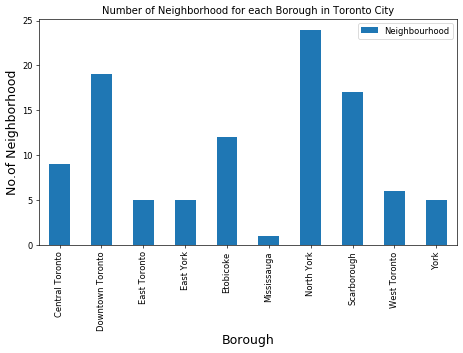

In [10]:
plt.figure(figsize=(9,5), dpi = 60)
plt.title('Number of Neighborhood for each Borough in Toronto City')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of Neighborhood', fontsize=15)
df1.groupby('Borough')['Neighbourhood'].count().plot(kind='bar')
plt.legend()
plt.show()

North York is the most famous Neighbourhood in Toronto so Only that will be used for further purpose other data will be dropped

In [11]:
north_york = df1[df1['Borough'] == 'North York'].reset_index(drop=True)
north_york.head()

Postcode     Borough               Neighbourhood   Latitude  Longitude
0      M2H  North York           Hillcrest Village  43.803762 -79.363452
1      M2J  North York  Fairview,Henry Farm,Oriole  43.778517 -79.346556
2      M2K  North York             Bayview Village  43.786947 -79.385975
3      M2L  North York     Silver Hills,York Mills  43.757490 -79.374714
4      M2M  North York      Newtonbrook,Willowdale  43.789053 -79.408493

FourSquare API will be used for and this are the client ID and Secret

In [12]:
CLIENT_ID = 'QI5DPRDVD4LZRVAYA0EXYDOY5Z3OOIIRLNNVKXRDZRXLMASG1'
CLIENT_SECRET='VFJ2W40FOK4LLKJNPAYWVCW5UUNS4RLMWMIO24WIPFBPTP1K'
VERSION = '20180605'

In [14]:
neighbourhood_latitude = north_york.loc[0, 'Latitude']
neighbourhood_longitude = north_york.loc[0, 'Longitude'] 
neighbourhood_name =north_york.loc[0, 'Neighbourhood']

In [15]:
LIMIT = 100
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighbourhood_latitude, 
    neighbourhood_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=QI5DPRDVD4LZRVAYA0EXYDOY5Z3OOIIRLNNVKXRDZRXLMAG1&client_secret=VFJ2W40FOK4LLKJNPAYWVCW5UUNS4RLMWMIO24WIPFBPTP1K&v=20180605&ll=43.8037622,-79.3634517&radius=500&limit=100'

Results returned from FourSquare API are in JSON Format

In [16]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e6e60e847b43d00234d3534'},
 'response': {'headerLocation': 'Toronto',
  'headerFullLocation': 'Toronto',
  'headerLocationGranularity': 'city',
  'totalResults': 5,
  'suggestedBounds': {'ne': {'lat': 43.808262204500004,
    'lng': -79.3572281853783},
   'sw': {'lat': 43.7992621955, 'lng': -79.3696752146217}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4ad9dce6f964a520651b21e3',
       'name': "Eagle's Nest Golf Club",
       'location': {'address': '10000 Dufferin Rd',
        'lat': 43.805454826002794,
        'lng': -79.36418592243415,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.805454826002794,
          'lng': -79.36418592243415}],
        'distance': 197,
        'cc': 'CA',
        'city': 'Toronto

Results obtained need to be flatten and converted in Tabular format

In [17]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [18]:
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues) # flatten JSON
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
nearby_venues.head()

name                categories        lat  \
0               Eagle's Nest Golf Club               Golf Course  43.805455   
1                      AY Jackson Pool                      Pool  43.804515   
2                         Villa Madina  Mediterranean Restaurant  43.801685   
3                    Duncan Creek Park                   Dog Run  43.805539   
4  A.Y. Jackson Secondary School Track        Athletics & Sports  43.805068   

         lng  
0 -79.364186  
1 -79.366138  
2 -79.363938  
3 -79.360695  
4 -79.366677

In [19]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

It will print the venues of the neighbourhood

In [20]:
north_york_venues = getNearbyVenues(names=north_york['Neighbourhood'],
                                   latitudes=north_york['Latitude'],
                                   longitudes=north_york['Longitude']
                                  )

Hillcrest Village
Fairview,Henry Farm,Oriole
Bayview Village
Silver Hills,York Mills
Newtonbrook,Willowdale
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park,Don Mills South
Bathurst Manor,Downsview North,Wilson Heights
Northwood Park,York University
CFB Toronto,Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Bedford Park,Lawrence Manor East
Lawrence Heights,Lawrence Manor
Glencairn
Downsview,North Park,Upwood Park
Humber Summit
Emery,Humberlea


In [22]:
north_york_venues.groupby('Neighbourhood').count()

Neighbourhood Latitude  \
Neighbourhood                                                           
Bathurst Manor,Downsview North,Wilson Heights                      19   
Bayview Village                                                     4   
Bedford Park,Lawrence Manor East                                   25   
CFB Toronto,Downsview East                                          3   
Don Mills North                                                     5   
Downsview Central                                                   3   
Downsview Northwest                                                 4   
Downsview West                                                      5   
Downsview,North Park,Upwood Park                                    4   
Emery,Humberlea                                                     1   
Fairview,Henry Farm,Oriole                                         63   
Flemingdon Park,Don Mills South                                    21   
Glencairn                                                           5   
Hillcrest Village                                                   5   
Humber Summit                                                       2   
Lawrence Heights,Lawrence Manor                                    14   
Northwood Park,York University                                      5   
Parkwoods                                                           2   
Silver Hills,York Mills                                             2   
Victoria Village                                                    5   
Willowdale South                                                   35   
Willowdale West                                                     6   
York Mills West                                                     4   

                                               Neighbourhood Longitude  Venue  \
Neighbourhood                                                                   
Bathurst Manor,Downsview North,Wilson Heights                       19     19   
Bayview Village                                                      4      4   
Bedford Park,Lawrence Manor East                                    25     25   
CFB Toronto,Downsview East                                           3      3   
Don Mills North                                                      5      5   
Downsview Central                                                    3      3   
Downsview Northwest                                                  4      4   
Downsview West                                                       5      5   
Downsview,North Park,Upwood Park                                     4      4   
Emery,Humberlea                                                      1      1   
Fairview,Henry Farm,Oriole                                          63     63   
Flemingdon Park,Don Mills South                                     21     21   
Glencairn                                                            5      5   
Hillcrest Village                                                    5      5   
Humber Summit                                                        2      2   
Lawrence Heights,Lawrence Manor                                     14     14   
Northwood Park,York University                                       5      5   
Parkwoods                                                            2      2   
Silver Hills,York Mills                                              2      2   
Victoria Village                                                     5      5   
Willowdale South                                                    35     35   
Willowdale West                                                      6      6   
York Mills West                                                      4      4   

                                               Venue Latitude  \
Neighbourhood                                                   
Bathurst Manor,Downsview North,Wilson Heights              19   


In [24]:
print('There are {} uniques categories.'.format(len(north_york_venues['Venue Category'].unique())))

There are 105 uniques categories.


Top 10 famous venue in North York 

In [25]:
north_york_venues['Venue Category'].value_counts()[:10].index.tolist()

['Coffee Shop',
 'Clothing Store',
 'Restaurant',
 'Park',
 'Japanese Restaurant',
 'Sandwich Place',
 'Pizza Place',
 'Grocery Store',
 'Fast Food Restaurant',
 'Sushi Restaurant']

# Now let's explore New York Neighbourhood 

In [27]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json
from geopy.geocoders import Nominatim
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium

Data of New York is in JSON format and needs to be converted

In [28]:
with open('nyu_2451_34572-geojson.json') as json_data:
    newyork_data = json.load(json_data)
    
newyork_data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

In [36]:
neighbourhoods_data = newyork_data['features']
neighbourhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

In [37]:
column_names = ['Borough', 'Neighbourhood', 'Latitude', 'Longitude'] 
neighbourhoods = pd.DataFrame(columns=column_names)
neighbourhoods

Empty DataFrame
Columns: [Borough, Neighbourhood, Latitude, Longitude]
Index: []

In [38]:

for data in neighbourhoods_data:
    borough = neighbourhood_name = data['properties']['borough']
    neighbourhood_name = data['properties']['name']
    neighbourhood_latlon = data['geometry']['coordinates']
    neighbourhood_lat = neighbourhood_latlon[1]
    neighbourhood_lon = neighbourhood_latlon[0]
    neighbourhoods = neighbourhoods.append({'Borough': borough,
                                          'Neighbourhood': neighbourhood_name,
                                          'Latitude': neighbourhood_lat,
                                          'Longitude': neighbourhood_lon}, ignore_index=True)

In [ ]:
df2=neighbourhoods

Now after data is been converted the map of new york with it's neighbourhood is creaated

In [39]:
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=11)
for lat, lng, label in zip(neighbourhoods['Latitude'],neighbourhoods['Longitude'],neighbourhoods['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

Most poular neighbourhood are plotted and Queens is the most popular neighbourhood in New York

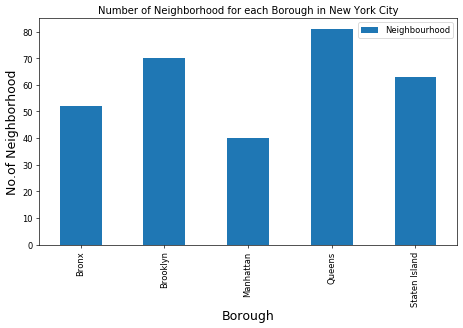

In [40]:
plt.figure(figsize=(9,5), dpi = 60)
plt.title('Number of Neighborhood for each Borough in New York City')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of Neighborhood', fontsize=15)
neighbourhoods.groupby('Borough')['Neighbourhood'].count().plot(kind='bar')
plt.legend()
plt.show()

In [41]:
queens_data = neighbourhoods[neighbourhoods['Borough'] == 'Queens'].reset_index(drop=True)
queens_data.head()

Borough    Neighbourhood   Latitude  Longitude
0  Queens          Astoria  40.768509 -73.915654
1  Queens         Woodside  40.746349 -73.901842
2  Queens  Jackson Heights  40.751981 -73.882821
3  Queens         Elmhurst  40.744049 -73.881656
4  Queens     Howard Beach  40.654225 -73.838138

Now FourSquare API are used to get venues of neighbourhood

In [42]:
queens_data.loc[0, 'Neighbourhood']

'Astoria'

In [43]:
neighbourhood_latitude = queens_data.loc[0, 'Latitude']
neighbourhood_longitude = queens_data.loc[0, 'Longitude']
neighbourhood_name = queens_data.loc[0, 'Neighbourhood']

In [44]:
LIMIT = 100
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighbourhood_latitude, 
    neighbourhood_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=QI5DPRDVD4LZRVAYA0EXYDOY5Z3OOIIRLNNVKXRDZRXLMAG1&client_secret=VFJ2W40FOK4LLKJNPAYWVCW5UUNS4RLMWMIO24WIPFBPTP1K&v=20180605&ll=40.76850859335492,-73.91565374304234&radius=500&limit=100'

In [45]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e6e6454c546f3001bae2021'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': '$-$$$$', 'key': 'price'},
    {'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Astoria',
  'headerFullLocation': 'Astoria, Queens',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 111,
  'suggestedBounds': {'ne': {'lat': 40.773008597854925,
    'lng': -73.90972309237958},
   'sw': {'lat': 40.76400858885492, 'lng': -73.9215843937051}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4bdf502a89ca76b062b75d5e',
       'name': 'Favela Grill',
       'location': {'address': '33-18 28th Ave',
        'crossStreet': 'btwn 33rd & 34th St.',
        'lat': 40.76734843380796,
        'lng': -73.9178974

In [46]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

JSOn data needs to be converted

In [47]:
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
nearby_venues.head()

name            categories        lat        lng
0        Favela Grill  Brazilian Restaurant  40.767348 -73.917897
1      Orange Blossom          Gourmet Shop  40.769856 -73.917012
2    Titan Foods Inc.          Gourmet Shop  40.769198 -73.919253
3     CrossFit Queens                   Gym  40.769404 -73.918977
4  Simply Fit Astoria                   Gym  40.769114 -73.912403

In [48]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [49]:
queens_venues = getNearbyVenues(names=queens_data['Neighbourhood'],
                                   latitudes=queens_data['Latitude'],
                                   longitudes=queens_data['Longitude']
                                  )

Astoria
Woodside
Jackson Heights
Elmhurst
Howard Beach
Corona
Forest Hills
Kew Gardens
Richmond Hill
Flushing
Long Island City
Sunnyside
East Elmhurst
Maspeth
Ridgewood
Glendale
Rego Park
Woodhaven
Ozone Park
South Ozone Park
College Point
Whitestone
Bayside
Auburndale
Little Neck
Douglaston
Glen Oaks
Bellerose
Kew Gardens Hills
Fresh Meadows
Briarwood
Jamaica Center
Oakland Gardens
Queens Village
Hollis
South Jamaica
St. Albans
Rochdale
Springfield Gardens
Cambria Heights
Rosedale
Far Rockaway
Broad Channel
Breezy Point
Steinway
Beechhurst
Bay Terrace
Edgemere
Arverne
Rockaway Beach
Neponsit
Murray Hill
Floral Park
Holliswood
Jamaica Estates
Queensboro Hill
Hillcrest
Ravenswood
Lindenwood
Laurelton
Lefrak City
Belle Harbor
Rockaway Park
Somerville
Brookville
Bellaire
North Corona
Forest Hills Gardens
Jamaica Hills
Utopia
Pomonok
Astoria Heights
Hunters Point
Sunnyside Gardens
Blissville
Roxbury
Middle Village
Malba
Hammels
Bayswater
Queensbridge


Venues of Queens are listed

In [50]:
queens_venues.head()

Neighbourhood  Neighbourhood Latitude  Neighbourhood Longitude  \
0       Astoria               40.768509               -73.915654   
1       Astoria               40.768509               -73.915654   
2       Astoria               40.768509               -73.915654   
3       Astoria               40.768509               -73.915654   
4       Astoria               40.768509               -73.915654   

                Venue  Venue Latitude  Venue Longitude        Venue Category  
0        Favela Grill       40.767348       -73.917897  Brazilian Restaurant  
1      Orange Blossom       40.769856       -73.917012          Gourmet Shop  
2    Titan Foods Inc.       40.769198       -73.919253          Gourmet Shop  
3     CrossFit Queens       40.769404       -73.918977                   Gym  
4  Simply Fit Astoria       40.769114       -73.912403                   Gym

In [51]:
print('There are {} uniques categories.'.format(len(queens_venues['Venue Category'].unique())))

There are 266 uniques categories.


In [52]:
queens_venues.groupby('Venue Category').count()

Neighbourhood  \
Venue Category                                            
Accessories Store                                     2   
Afghan Restaurant                                     2   
Airport Terminal                                      1   
American Restaurant                                  20   
Arepa Restaurant                                      4   
Argentinian Restaurant                                2   
Art Gallery                                           1   
Art Museum                                            1   
Arts & Crafts Store                                   2   
Arts & Entertainment                                  1   
Asian Restaurant                                     16   
Athletics & Sports                                    3   
Auto Dealership                                       1   
Automotive Shop                                       2   
BBQ Joint                                             7   
Bagel Shop                                           22   
Bakery                                               55   
Bank                                                 49   
Bar                                                  47   
Baseball Field                                        4   
Basketball Court                                      3   
Bath House                                            1   
Beach                                                29   
Beach Bar                                             1   
Bed & Breakfast                                       1   
Beer Garden                                           3   
Bike Trail                                            1   
Bistro                                                2   
Board Shop                                            3   
Bookstore                                             2   
Boutique                                              3   
Bowling Alley                                         4   
Brazilian Restaurant                                  3   
Breakfast Spot                                        9   
Brewery                                               5   
Bubble Tea Shop                                      14   
Buffet                                                1   
Burger Joint                                         10   
Burrito Place                                         1   
Bus Station                                          28   
Bus Stop                                              9   
Business Service                                      2   
Café                                                 23   
Cajun / Creole Restaurant                             4   
Candy Store                                           3   
Cantonese Restaurant                                  1   
Caribbean Restaurant                                 18   
Check Cashing Service                                 1   
Chinese Restaurant                                   62   
Church                                                2   
Climbing Gym                                          1   
Clothing Store                                       14   
Cocktail Bar                                          4   
Coffee Shop                                          38   
College Academic Building                             1   
College Basketball Court                              1   
College Cafeteria                                     1   
Colombian Restaurant                                  3   
Comedy Club                                           1   
Comfort Food Restaurant                               2   
Concert Hall                                          1   
Construction & Landscaping                            4   
Convenience Store                                    16   
Cosmetics Shop                                       18   
Cuban Restaurant                                      2   
Cycle Studio                                          1   
Dance Studio                  

The most famous venues in Queens are

In [53]:
queens_venues['Venue Category'].value_counts()[:10].index.tolist()

['Pizza Place',
 'Deli / Bodega',
 'Chinese Restaurant',
 'Bakery',
 'Donut Shop',
 'Pharmacy',
 'Bank',
 'Bar',
 'Grocery Store',
 'Sandwich Place']